In [1]:
from PIL import Image
from glob import glob
import torch.nn as nn
import numpy as np
import torchvision.transforms as tfms
import gc
import torch
import os

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

class ResizeToEven(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        if len(x.shape) == 4:
            _, _, h, w = x.shape
        else:
            _, h, w = x.shape
        
        if h % 2 != 0:
            h -= 1
        if w % 2 != 0:
            w -= 1
        
        resized_x = x[:, :h, :w]
        
        return resized_x
    
    
class ScaleToFit(nn.Module):
    def __init__(self, max_size=1280):
        super().__init__()

        self.max_size = max_size

    def forward(self, img: Image):
        w, h = img.size
        max_dim_size = max(h, w)

        if max_dim_size > self.max_size:
            if max_dim_size == h:
                new_h = self.max_size
                new_w = int(new_h * w / h)
            else:
                new_w = self.max_size
                new_h = int(h * new_w / w)
            img = img.resize((new_w, new_h), Image.BICUBIC)

        return img
    
GET_IMG_TFMS = lambda max_size: tfms.Compose([
    ScaleToFit(max_size),
    tfms.ToTensor(),
    ResizeToEven(),
    tfms.Normalize(MEAN, STD)
])

IMG_REV_TFMS = tfms.Compose([
    tfms.Normalize(mean = [ 0., 0., 0. ], std = 1 / STD),
    tfms.Normalize(mean = -MEAN, std = [ 1., 1., 1. ])
])

# Paths and Setup

In [2]:
# Download face2arcane inference models as an example

# !gdown https://drive.google.com/uc?id=1_YoeJ0h_t7XjytLKXrLBTS1aZ-qcrSlC
# !unzip models.zip && rm models.zip

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHTS_PATH = f'{DEVICE}-resnet34.pt' # or specify your own weights here
IMG_TFMS = GET_IMG_TFMS(1024) # Specify maximum image dimension here
TEST_DIR = "/home/artermiloff/Downloads/ArcaneValPhotosClean/" # Specify test images directory path
SAVE_IMAGES = False # Save images to results/ directory
DISPLAY_IMAGES = True # Display images during inference

# preparing model for inference
unet_model = torch.jit.load(WEIGHTS_PATH)
unet_model.eval()
_ = unet_model.to(DEVICE)

# Inference

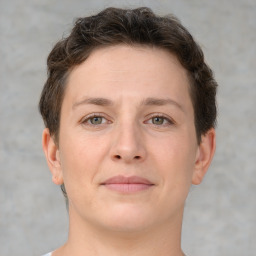

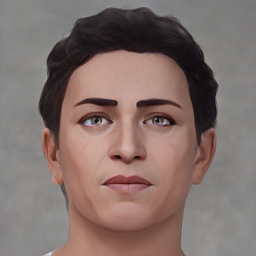

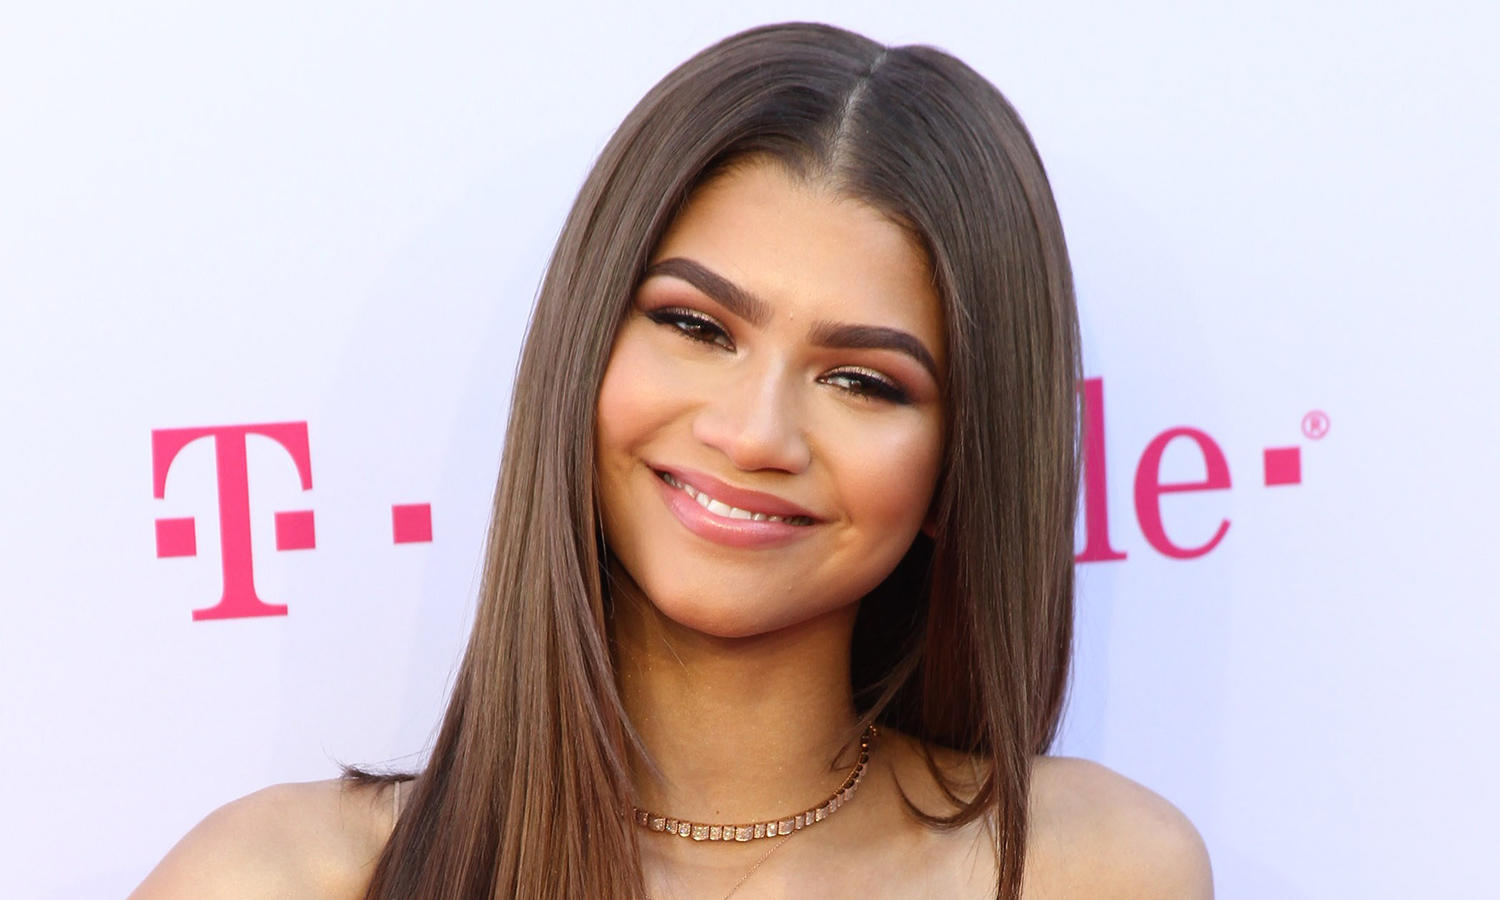

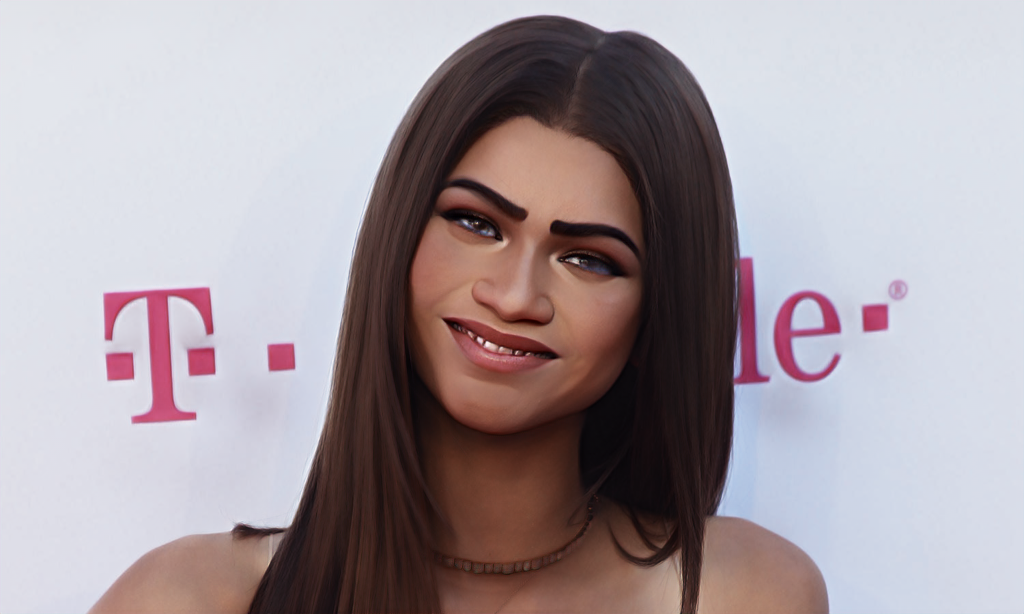

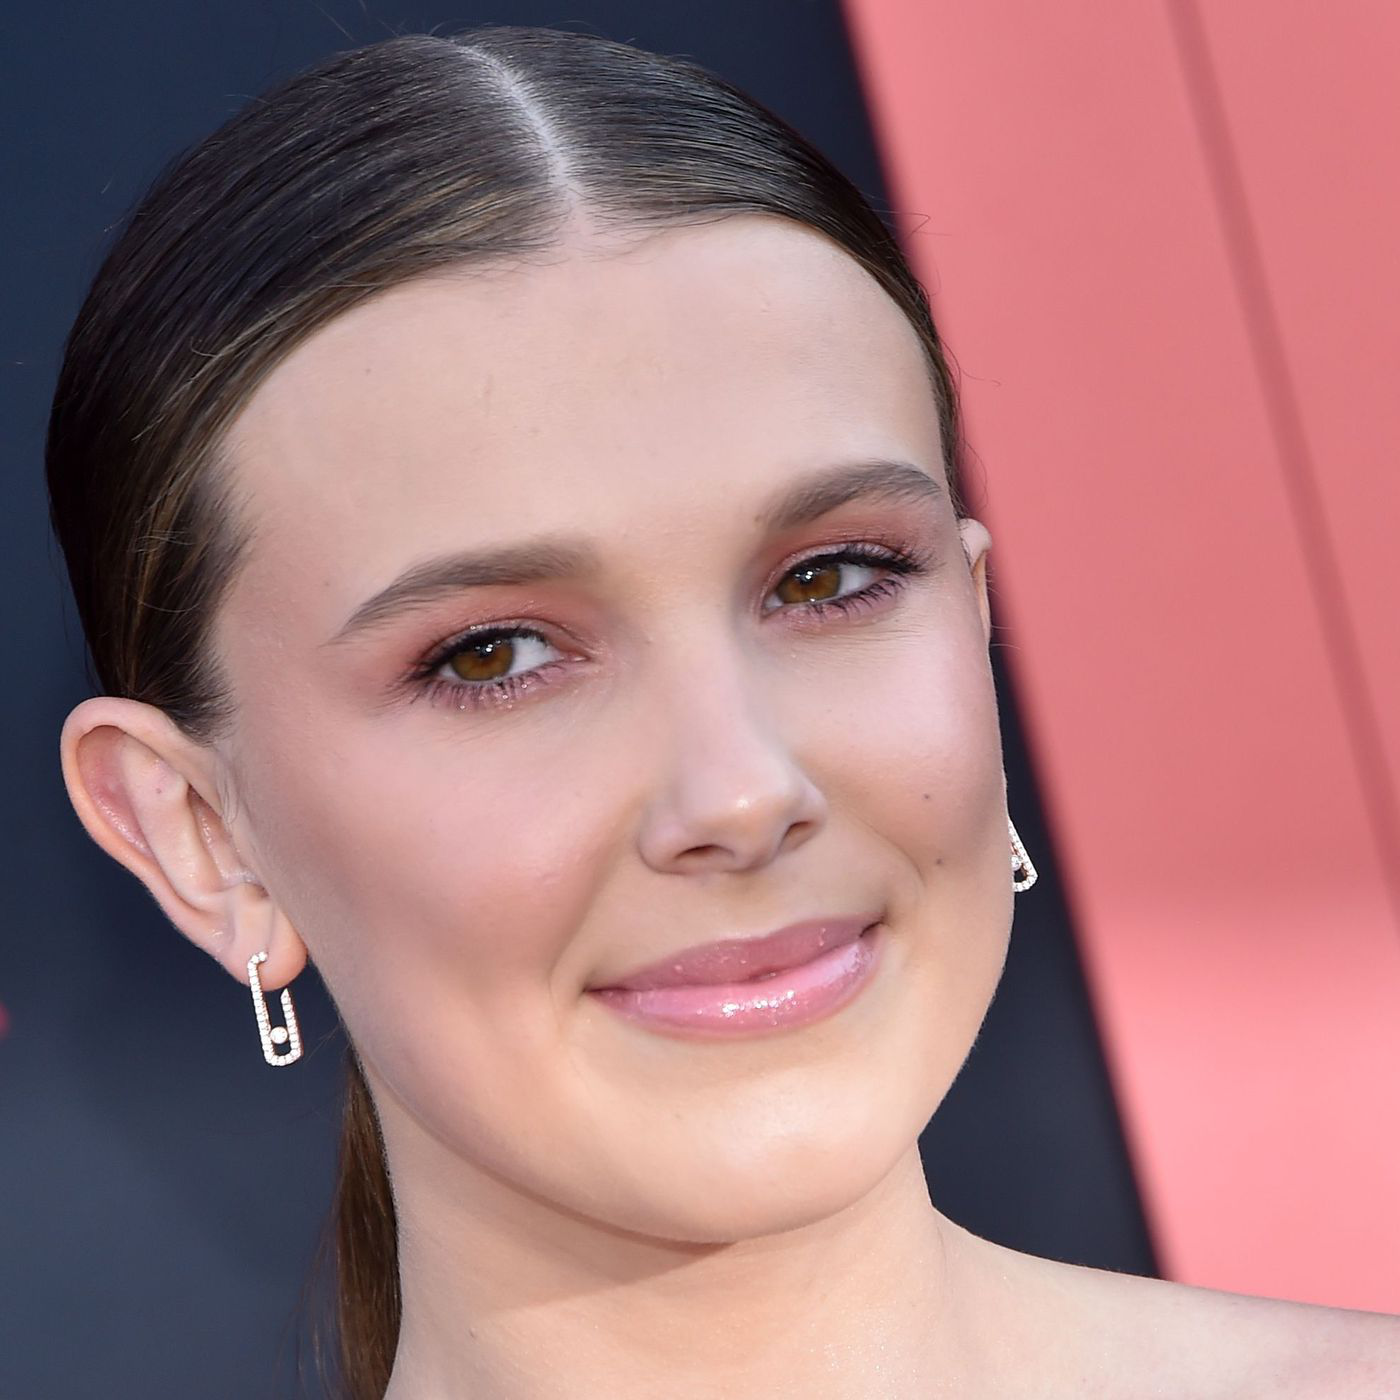

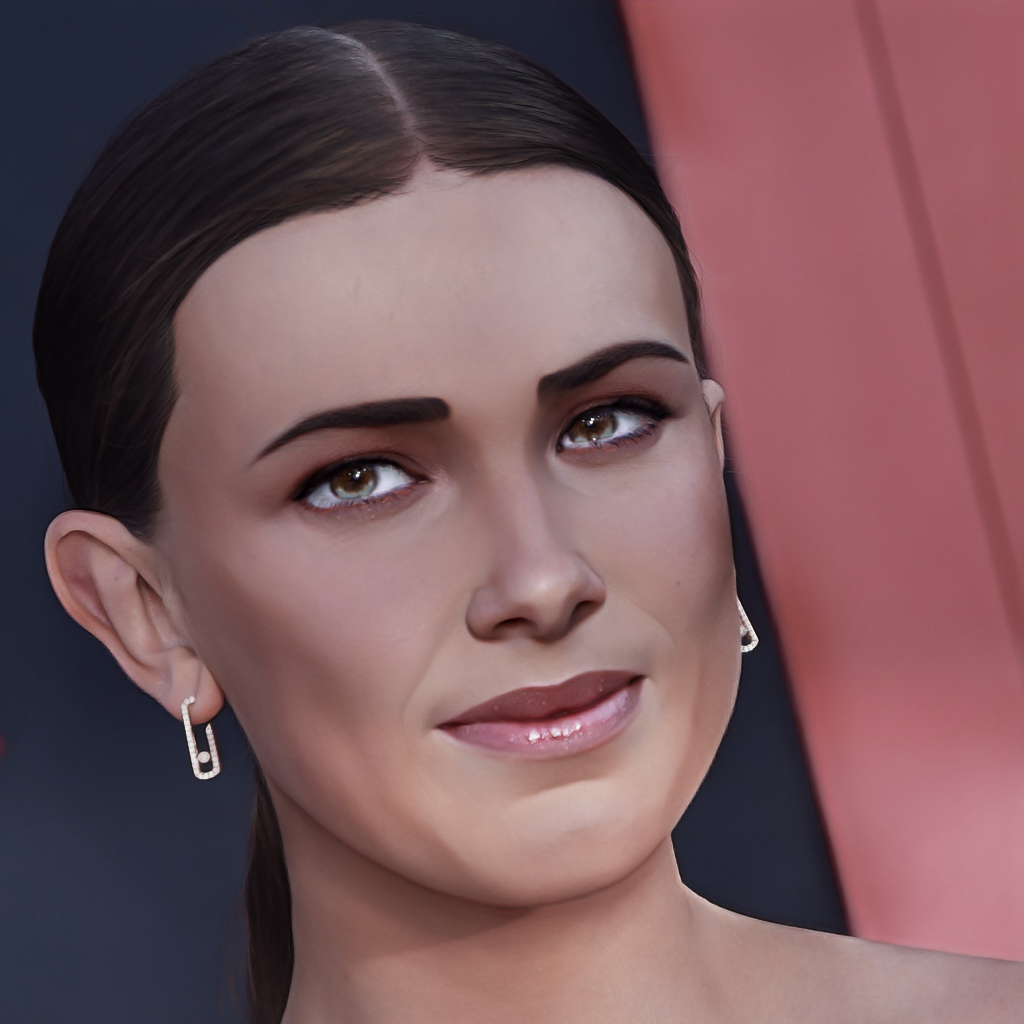

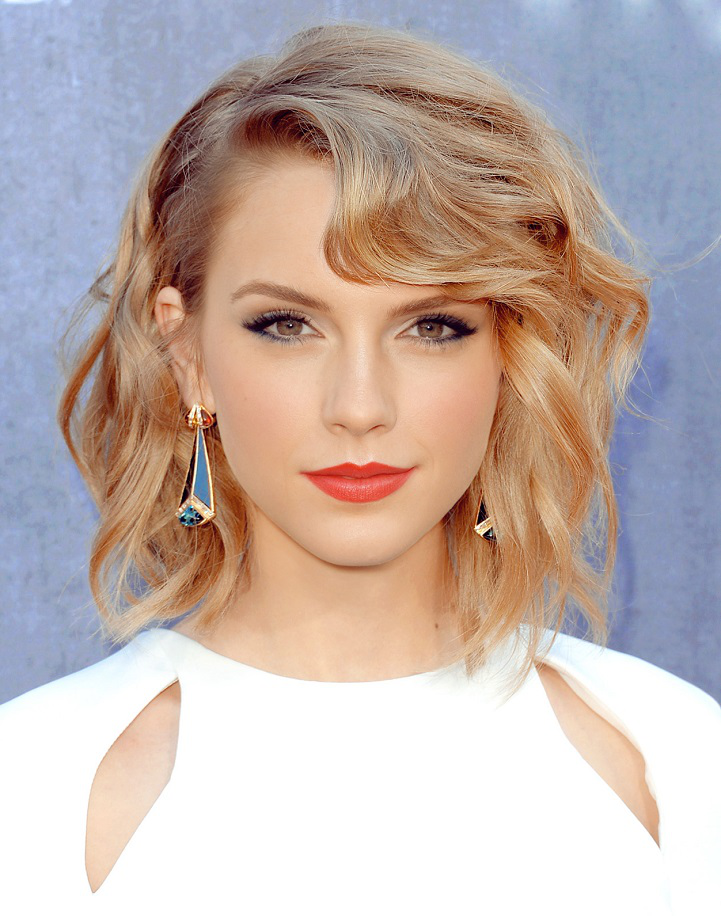

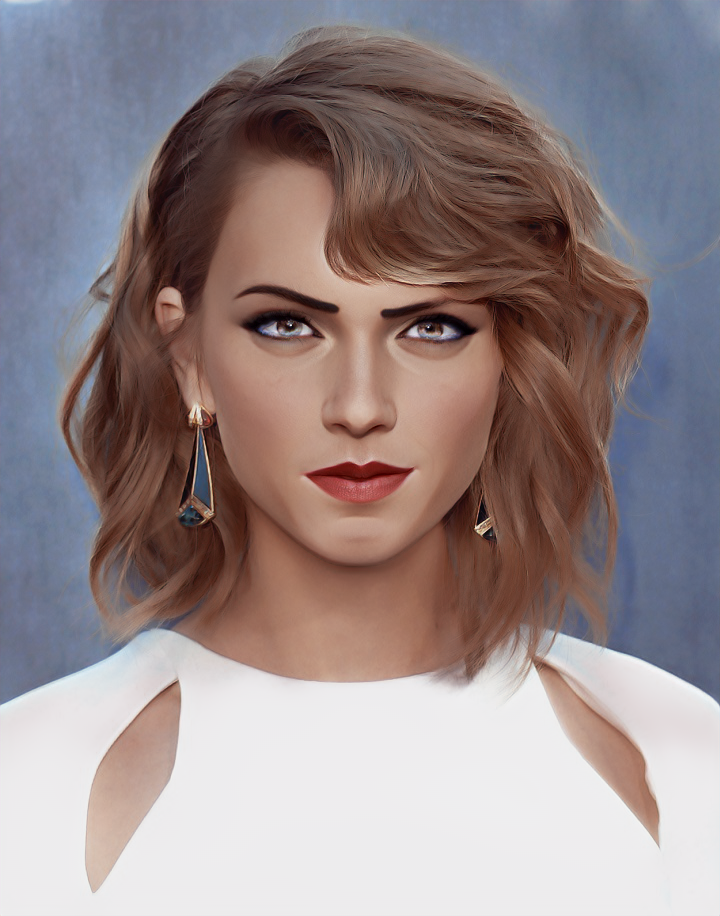

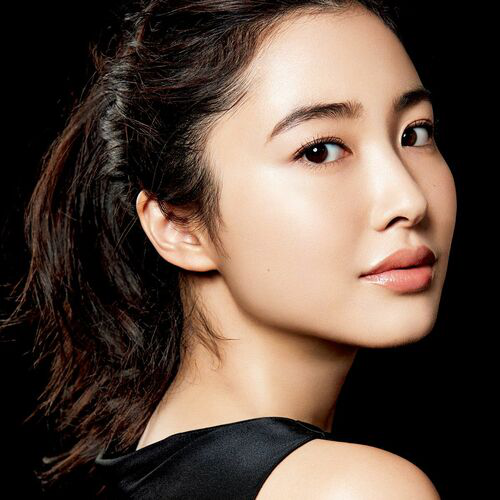

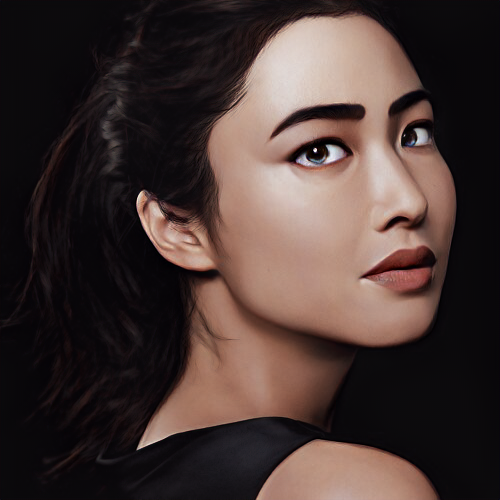

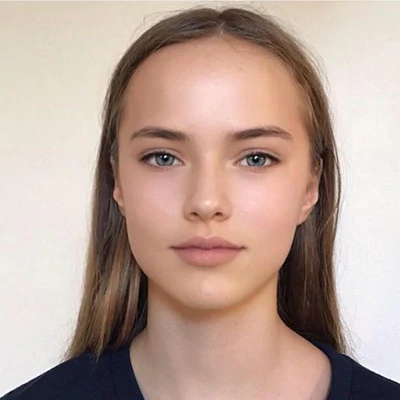

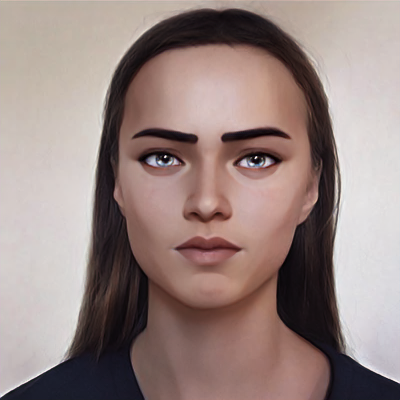

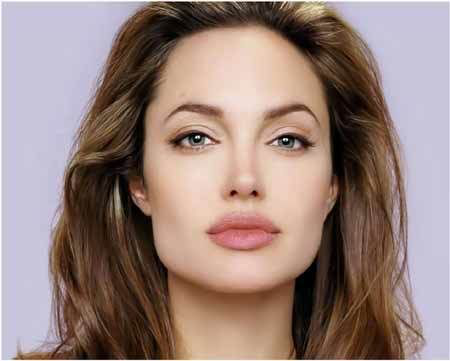

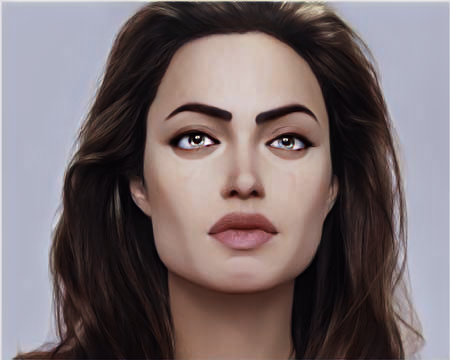

In [4]:
files = sorted(glob(TEST_DIR + "/*"))
out_dir = "results/"
os.makedirs(out_dir, exist_ok=True)


for file in files:
    img = Image.open(file)
    # print(file)
    if DISPLAY_IMAGES:
        display(img)
    img_tensor = IMG_TFMS(img).unsqueeze(dim=0).to(DEVICE)
    with torch.inference_mode():
        prediction = unet_model(img_tensor).squeeze().detach().cpu()
        pred_img = IMG_REV_TFMS(prediction).clamp(min=0, max=1)
        pred_img = tfms.ToPILImage()(pred_img)
        if DISPLAY_IMAGES:
            display(pred_img)
        if SAVE_IMAGES:
            pred_img.save(out_dir + file.split("/")[-1])
    img_tensor = None
    prediction = None
    pred_img = None
    gc.collect()